In [1]:
## Keras configuration

# Set KERAS backend to Theano
import os
os.environ['KERAS_BACKEND']='theano'

# Load Keras
import keras

# Load the libraries
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

Using Theano backend.


In [2]:
import pandas as pd
from functools import reduce

In [3]:
# Load Data into array

nodes = []
for x in range(0, 5):
    nodes.append(pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n' + str(x+150) +'.dat',
                     error_bad_lines=False, header=1))
    print("Loaded file MDA300n"+str(x+150)+".dat")

Loaded file MDA300n155.dat


In [4]:
# Split TimeStamp into Date and Time columns and 

numNodes = len(nodes)
for y in range(numNodes):
    nodes[y][['DATE','TIME']] = nodes[y].TMSTAMP.str.split(expand=True)

In [5]:
for w in range(numNodes):
    nodes[w] = nodes[w].drop('TMSTAMP', 1)
    nodes[w] = nodes[w].drop('RECNBR', 1)
    nodes[w] = nodes[w].drop('PARENT', 1)
    nodes[w] = nodes[w].drop('SOLAROCV', 1)
    nodes[w] = nodes[w].drop('VBATT', 1)
    nodes[w] = nodes[w].drop('TEMP', 1)
    nodes[w] = nodes[w].drop('DATE', 1)

In [6]:
print(nodes[0].columns)

Index(['IRRADIANCE', 'TIME'], dtype='object')


In [7]:
# Explore data to see the distribution of irradiance values

count = []
for z in range(numNodes):
    count.append(nodes[z].IRRADIANCE.value_counts())

In [8]:
count[0].index

Float64Index([   2.81,    8.44,    5.63,   11.25,   19.69,   16.88,   33.76,
                14.07,   25.32,   22.51,
              ...
              1229.52, 1240.77, 1204.19, 1198.57, 1212.63, 1260.46, 1201.38,
              1263.28, 1232.33, 1291.41],
             dtype='float64', length=439)

In [9]:
# Select the 10 class values
class_values = [2.92, 8.75, 3.07, 2.81, 3.17, 8.44, 2.74, 2.98, 3.14, 3.52]

In [10]:
# Subset data by the selected class values

subset = []
for a in range(numNodes):
    subset.append(nodes[a][nodes[a].IRRADIANCE.isin(class_values)])

In [11]:
print(nodes[0].columns)

Index(['IRRADIANCE', 'TIME'], dtype='object')


In [12]:
# Merge the subsets

data = reduce(lambda  left,right: pd.merge(left,right,on=['IRRADIANCE','TIME'],how='outer'), nodes)

In [13]:
data.head()
print(data.size)

125338


In [14]:
# Transform Time column into numeric (hours)
data.TIME = pd.to_timedelta(data.TIME)
data.TIME = data.TIME.dt.seconds/3600

In [15]:
# Creating labels:

# Convert the labels into categorical classification
# Class values: {2.92, 8.75, 3.07, 2.81} correspond to {0, 1, 2, 3}
data.loc[data.IRRADIANCE==2.92, 'IRRADIANCE'] = 0
data.loc[data.IRRADIANCE==8.75, 'IRRADIANCE'] = 1
data.loc[data.IRRADIANCE==3.07, 'IRRADIANCE'] = 2
data.loc[data.IRRADIANCE==2.81, 'IRRADIANCE'] = 3
data.loc[data.IRRADIANCE==3.17, 'IRRADIANCE'] = 4
# data.loc[data.IRRADIANCE==8.44, 'IRRADIANCE'] = 5
# data.loc[data.IRRADIANCE==2.74, 'IRRADIANCE'] = 6
# data.loc[data.IRRADIANCE==2.98, 'IRRADIANCE'] = 7
# data.loc[data.IRRADIANCE==3.14, 'IRRADIANCE'] = 8
# data.loc[data.IRRADIANCE==3.52, 'IRRADIANCE'] = 9

In [16]:
data.head()

,IRRADIANCE,TIME
0,8.44,19.305833
1,8.44,19.338056
2,8.44,19.370278
3,5.63,19.386667
4,5.63,19.418889


In [17]:
# Split data into three parts: training(40%), testing(30%), validation(30%)
# Use scikit-learn

import sklearn
from sklearn.model_selection import train_test_split

Train_Set, Test_Set = train_test_split(data, train_size=0.4, test_size=0.3, shuffle=True)

In [18]:
# Extract the feature columns: IRRADIANCE, TIME

#X_train = np.array(Train_Set[['IRRADIANCE', 'TIME']]).astype('float64')
#X_test = np.array(Test_Set[['IRRADIANCE','TIME']]).astype('float64')

X_train = np.array(Train_Set[['IRRADIANCE','TIME']]).astype('float64')
X_test = np.array(Test_Set[['IRRADIANCE','TIME']]).astype('float64')

# Input Shape
shape_ord = (X_train[0].shape)

In [19]:
# Extract the label column: IRRADIANCE

# Cast the label as integer
Y_train = np.array(Train_Set[['IRRADIANCE']]).astype('float64')
Y_test = np.array(Test_Set[['IRRADIANCE']]).astype('float64')

from keras.utils import to_categorical
# Convert the labels into categorical form
Y_train = to_categorical(Y_train, num_classes=8750)
Y_test = to_categorical(Y_test, num_classes=8750)

In [20]:
shape_ord

(2,)

### Training the final model

In [21]:
# Initialize the parameters
# Number of epochs
nb_epochs = 3
# Batch size
batch_size = 128
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

In [22]:
model = Sequential()

model.add(Dense(10, activation='relu', input_dim=2))
model.add(Dropout(0.4))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8750, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8750)              96250     
Total params: 96,390
Trainable params: 96,390
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist = model.fit(X_train, Y_train, batch_size=batch_size,validation_split=0.33, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 25067 samples, validate on 18801 samples
Epoch 1/3
25067/25067 [==============================] - 26s 1ms/step - loss: 6.2890 - acc: 0.5457 - val_loss: 7.2819 - val_acc: 0.5482
Epoch 2/3
25067/25067 [==============================] - 25s 1ms/step - loss: 6.1929 - acc: 0.5511 - val_loss: 7.2819 - val_acc: 0.5482
Epoch 3/3
25067/25067 [==============================] - 24s 975us/step - loss: 6.4628 - acc: 0.5511 - val_loss: 7.2819 - val_acc: 0.5482


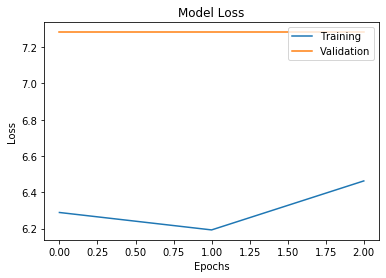

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Model Accuracy')
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.legend(['Training', 'Validation'], loc='upper right')
# plt.show()

In [25]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 7.281905469346076
Test Accuracy: 0.5482155204668913


Prediction

In [26]:
input = []
input.append(pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n155.dat',
                     error_bad_lines=False, header=1))
print("Loaded file MDA300n155.dat")

Loaded file MDA300n155.dat


In [1]:
ghi = pd.read_csv('https://raw.githubusercontent.com/MatthewJahn/CIS3296-Irradiance-Project/master/GHIsolcast.csv',
                     error_bad_lines=False, header=0)
print("Loaded file GHIsolcast.csv")

print(ghi.columns)
ghi[['DATE','TIME']] = ghi.PeriodStart.str.split('T', expand=True)
ghi.TIME = ghi.TIME.str[0:8]
ghi = ghi.drop('Period', 1)
ghi = ghi.drop('PeriodStart', 1)
ghi = ghi.drop('PeriodEnd', 1)
ghi = ghi.drop(ghi.index[24:])

print(ghi.columns)
ghi.head(24)

NameError: name 'pd' is not defined

In [28]:
numRec = len(input)
for y in range(numRec):
    input[y][['DATE','TIME']] = input[y].TMSTAMP.str.split(' ', expand=True)
    input[y].TIME = input[y].TIME.str[0:3] + '00:00'
    input[y].drop_duplicates(subset='TIME',keep='first',inplace=True) #this needs to applied only every date instead of over the whole thing if we want a longer graph
    

In [29]:
for w in range(numRec):
    input[w] = input[w].drop('TMSTAMP', 1)
    input[w] = input[w].drop('RECNBR', 1)
    input[w] = input[w].drop('PARENT', 1)
    input[w] = input[w].drop('SOLAROCV', 1)
    input[w] = input[w].drop('VBATT', 1)
    input[w] = input[w].drop('TEMP', 1)
    input[w] = input[w].drop('DATE', 1)

input[w].head(24)

,IRRADIANCE,TIME
0,8.44,19:00:00
27,2.81,20:00:00
85,2.81,21:00:00
140,2.81,22:00:00
202,2.81,23:00:00
254,2.81,00:00:00
312,2.81,01:00:00
370,2.81,02:00:00
429,2.81,03:00:00
487,2.81,04:00:00


In [30]:
input = pd.DataFrame(input[0])

In [31]:
input.TIME = pd.to_timedelta(input.TIME)
input.TIME = input.TIME.dt.seconds/3600

In [35]:
output = model.predict_classes(input)
np.unique(output)

array([0., 1.], dtype=float32)

Text(0.5, 1.0, 'Model Prediction and GHI')

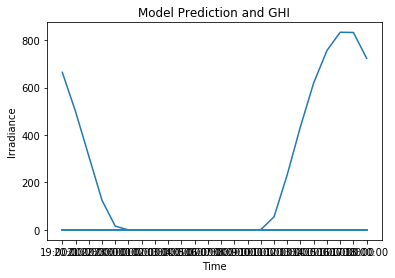

In [36]:
plt.plot(ghi.TIME, ghi.Ghi, output)
plt.xlabel('Time')
plt.ylabel('Irradiance')
plt.title('Model Prediction and GHI')

In [34]:
#node5real = [8.44, 2.81, 2.81 , 2.81, 2.81, 2.81, 2.81, 2.81, 2.81, 2.81, 2.81, 2.81, 5.63, 53.46, 106.91, 177.25, 261.66, 329.18, 562.71, 872.20, 185.69, 225.08, 880.64, 725.89]